# Skenario 3: Differential Learning Rates

Notebook ini menjalankan skenario ketiga dari penelitian transfer learning: **Differential Learning Rates**.

**Tujuan:**
- Melatih model dengan memberikan *learning rate* (LR) yang berbeda untuk setiap grup layer.
- Idenya adalah layer awal (dekat input) yang menangkap fitur umum harus dilatih dengan LR sangat kecil untuk menjaga pengetahuannya, sementara layer akhir (dekat output) yang lebih spesifik untuk tugas baru dilatih dengan LR yang lebih besar.
- Membandingkan apakah teknik ini menghasilkan konvergensi yang lebih baik atau performa yang lebih tinggi.

**Metodologi:**
Parameter model akan dibagi menjadi beberapa grup, dan setiap grup akan diberikan LR yang berbeda:
1.  **Grup 1 (LR Paling Besar):** *Classifier Head* dan *Pooler*. Paling spesifik untuk tugas.
2.  **Grup 2 (LR Besar):** Layer-layer encoder teratas.
3.  **Grup 3 (LR Sedang):** Layer-layer encoder tengah.
4.  **Grup 4 (LR Paling Kecil):** Layer-layer encoder bawah dan layer *Embeddings*. Paling umum dan fundamental.

# Import Libraries

In [ ]:
# %%capture
%pip install transformers[torch] datasets scikit-learn pandas matplotlib seaborn tqdm --upgrade

In [2]:

# Impor pustaka yang dibutuhkan
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, get_linear_schedule_with_warmup, logging
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import gc

logging.set_verbosity_error()
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set_theme(style="whitegrid", palette="muted")
plt.style.use('default')

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {DEVICE}")

MODEL_CONFIGS = {
    "IndoBERTbase": "indobenchmark/indobert-base-p1",
    "IndoBERTweet": "indolem/indobertweet-base-uncased",
    "RoBERTa": "databoks-irfan/twitter-comment-roberta-base-indonesian-smsa"
}

DATA_PATH = '../data/bbm_data_preprocesed.csv' 

LR_CLASSIFIER = 5e-5
LR_TOP_LAYERS = 2e-5
LR_MID_LAYERS = 1e-5
LR_BOTTOM_LAYERS = 5e-6

TOP_LAYER_START_INDEX = 8
MID_LAYER_START_INDEX = 4

EPOCHS = 4
RANDOM_STATE = 42
MAX_LEN = 128
BATCH_SIZE = 16
WEIGHT_DECAY = 0.01
DROPOUT_RATE = 0.2

Menggunakan perangkat: cuda


In [ ]:
class SentimentDataset(Dataset):
    """Dataset class untuk sentimen."""
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def load_and_split_data(path, text_column='text', label_column='sentiment', test_size=0.2, random_state=42):
    """Memuat data dari file CSV, membersihkan, dan membaginya menjadi set latih dan validasi."""
    print(f"Memuat data dari: {path}")
    try:
        df = pd.read_csv(path)
        label_map = {"neutral": 0, "positive": 1, "negative": 2}
        df['label_id'] = df[label_column].map(label_map)
        df.dropna(subset=[text_column, 'label_id'], inplace=True)
        df['label_id'] = df['label_id'].astype(int)

        texts = df[text_column].values; labels = df['label_id'].values
        splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, val_idx = next(splitter.split(texts, labels))
        
        train_texts, val_texts = texts[train_idx], texts[val_idx]
        train_labels, val_labels = labels[train_idx], labels[val_idx]
        
        print(f"Data berhasil dimuat dan dibagi. Train: {len(train_texts)}, Validation: {len(val_texts)}")
        
        return {
            "train_texts": train_texts, "train_labels": train_labels,
            "val_texts": val_texts, "val_labels": val_labels,
            "num_labels": len(label_map)
        }
    except FileNotFoundError:
        print(f"ERROR: File tidak ditemukan di path '{path}'. Mohon periksa kembali path file Anda.")
        return None
    except KeyError as e:
        print(f"ERROR: Kolom {e} tidak ditemukan di file CSV. Pastikan nama kolom di kode sesuai.")
        return None

data_dict = load_and_split_data(
    path=DATA_PATH,
    text_column='text',
    label_column='sentiment'
)

Memuat data dari: ../data/bbm_data_preprocesed.csv
Data berhasil dimuat dan dibagi. Train: 4604, Validation: 1151


In [5]:
def compute_metrics(labels, preds):
    """Menghitung metrik evaluasi."""
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average='weighted', zero_division=0),
        "recall": recall_score(labels, preds, average='weighted', zero_division=0),
        "f1": f1_score(labels, preds, average='weighted', zero_division=0)
    }

def train_epoch(model, data_loader, optimizer, device, scaler, scheduler):
    """Satu epoch training."""
    model.train()
    total_loss, all_preds, all_labels = 0, [], []
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        with autocast(device_type=device.type, dtype=torch.float16):
            outputs = model(**batch)
            loss = outputs.loss
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item()
        all_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())
    return total_loss / len(data_loader), compute_metrics(all_labels, all_preds)

def evaluate_epoch(model, data_loader, device):
    """Satu epoch evaluasi."""
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    progress_bar = tqdm(data_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            with autocast(device_type=device.type, dtype=torch.float16):
                outputs = model(**batch)
            total_loss += outputs.loss.item()
            all_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())
    return total_loss / len(data_loader), compute_metrics(all_labels, all_preds)

In [9]:
def get_optimizer_grouped_parameters(model):
    """
    Mengelompokkan parameter model untuk Differential Learning Rates,
    dengan penanganan untuk model yang tidak memiliki pooler (seperti RoBERTa).
    """
    
    encoder_layers = model.base_model.encoder.layer
    
    optimizer_grouped_parameters = [
        {
            "params": model.classifier.parameters(),
            "lr": LR_CLASSIFIER,
        }
    ]
    
    if hasattr(model.base_model, 'pooler') and model.base_model.pooler is not None:
        optimizer_grouped_parameters.append({
            "params": model.base_model.pooler.parameters(),
            "lr": LR_CLASSIFIER,
        })
        print("Layer 'pooler' terdeteksi dan ditambahkan ke grup LR tertinggi.")
    else:
        print("Model ini tidak memiliki layer 'pooler'. Dilewati.")

    optimizer_grouped_parameters.append({
        "params": encoder_layers[TOP_LAYER_START_INDEX:].parameters(),
        "lr": LR_TOP_LAYERS,
    })

    optimizer_grouped_parameters.append({
        "params": encoder_layers[MID_LAYER_START_INDEX:TOP_LAYER_START_INDEX].parameters(),
        "lr": LR_MID_LAYERS,
    })
    
    optimizer_grouped_parameters.append({
        "params": encoder_layers[:MID_LAYER_START_INDEX].parameters(),
        "lr": LR_BOTTOM_LAYERS,
    })
    optimizer_grouped_parameters.append({
        "params": model.base_model.embeddings.parameters(),
        "lr": LR_BOTTOM_LAYERS,
        "weight_decay": 0.0
    })
    
    print("\nStruktur Differential Learning Rates:")
    print(f" - Classifier & Pooler (jika ada): {LR_CLASSIFIER}")
    print(f" - Top Encoder Layers:             {LR_TOP_LAYERS}")
    print(f" - Mid Encoder Layers:             {LR_MID_LAYERS}")
    print(f" - Bottom Layers & Embeddings:     {LR_BOTTOM_LAYERS}")
    
    return optimizer_grouped_parameters

def run_differential_lr_scenario(model_name_hf, data_dict, device):
    """Menjalankan siklus training Differential LR untuk satu model."""
    print(f"\nMemulai Skenario Differential LR untuk: {model_name_hf}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name_hf)
    train_dataset = SentimentDataset(data_dict['train_texts'], data_dict['train_labels'], tokenizer, MAX_LEN)
    val_dataset = SentimentDataset(data_dict['val_texts'], data_dict['val_labels'], tokenizer, MAX_LEN)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2)

    config = AutoConfig.from_pretrained(model_name_hf, num_labels=data_dict['num_labels'], classifier_dropout=DROPOUT_RATE)
    model = AutoModelForSequenceClassification.from_pretrained(model_name_hf, config=config).to(device)

    grouped_params = get_optimizer_grouped_parameters(model)
    optimizer = AdamW(grouped_params, weight_decay=WEIGHT_DECAY)
    scaler = GradScaler()
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    
    history = {
        'train_loss': [], 'train_accuracy': [], 'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_loss': [], 'val_accuracy': [], 'val_precision': [], 'val_recall': [], 'val_f1': []
    }
    
    for epoch in range(EPOCHS):
        print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
        train_loss, train_metrics = train_epoch(model, train_loader, optimizer, device, scaler, scheduler)
        val_loss, val_metrics = evaluate_epoch(model, val_loader, device)
        
        print(f"Train | Loss: {train_loss:.4f}, F1: {train_metrics['f1']:.4f}")
        print(f"Valid | Loss: {val_loss:.4f}, F1: {val_metrics['f1']:.4f}")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        for metric_name in ['accuracy', 'precision', 'recall', 'f1']:
            history[f'train_{metric_name}'].append(train_metrics[metric_name])
            history[f'val_{metric_name}'].append(val_metrics[metric_name])
            
    del model, tokenizer, optimizer, scaler, scheduler
    gc.collect()
    torch.cuda.empty_cache()
    return history

In [10]:
all_histories = {}

if data_dict:
    for model_alias, model_name_hf in MODEL_CONFIGS.items():
        history = run_differential_lr_scenario(
            model_name_hf=model_name_hf,
            data_dict=data_dict,
            device=DEVICE
        )
        all_histories[model_alias] = history
    print("\n\nEksperimen Skenario 3 (Differential LR) Selesai.")


Memulai Skenario Differential LR untuk: indobenchmark/indobert-base-p1
Layer 'pooler' terdeteksi dan ditambahkan ke grup LR tertinggi.

Struktur Differential Learning Rates:
 - Classifier & Pooler (jika ada): 5e-05
 - Top Encoder Layers:             2e-05
 - Mid Encoder Layers:             1e-05
 - Bottom Layers & Embeddings:     5e-06

--- Epoch 1/4 ---


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train | Loss: 0.5192, F1: 0.7749
Valid | Loss: 0.2895, F1: 0.8946

--- Epoch 2/4 ---


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train | Loss: 0.2590, F1: 0.9045
Valid | Loss: 0.2935, F1: 0.9045

--- Epoch 3/4 ---


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train | Loss: 0.2278, F1: 0.9102
Valid | Loss: 0.2509, F1: 0.9113

--- Epoch 4/4 ---


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train | Loss: 0.2116, F1: 0.9185
Valid | Loss: 0.2532, F1: 0.9122

Memulai Skenario Differential LR untuk: indolem/indobertweet-base-uncased
Layer 'pooler' terdeteksi dan ditambahkan ke grup LR tertinggi.

Struktur Differential Learning Rates:
 - Classifier & Pooler (jika ada): 5e-05
 - Top Encoder Layers:             2e-05
 - Mid Encoder Layers:             1e-05
 - Bottom Layers & Embeddings:     5e-06

--- Epoch 1/4 ---


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train | Loss: 0.4129, F1: 0.8284
Valid | Loss: 0.2815, F1: 0.9053

--- Epoch 2/4 ---


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train | Loss: 0.2178, F1: 0.9181
Valid | Loss: 0.2953, F1: 0.9043

--- Epoch 3/4 ---


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train | Loss: 0.1677, F1: 0.9376
Valid | Loss: 0.2699, F1: 0.9089

--- Epoch 4/4 ---


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train | Loss: 0.1493, F1: 0.9491
Valid | Loss: 0.2862, F1: 0.9159

Memulai Skenario Differential LR untuk: databoks-irfan/twitter-comment-roberta-base-indonesian-smsa
Model ini tidak memiliki layer 'pooler'. Dilewati.

Struktur Differential Learning Rates:
 - Classifier & Pooler (jika ada): 5e-05
 - Top Encoder Layers:             2e-05
 - Mid Encoder Layers:             1e-05
 - Bottom Layers & Embeddings:     5e-06

--- Epoch 1/4 ---


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train | Loss: 2.7329, F1: 0.5143
Valid | Loss: 0.7814, F1: 0.5923

--- Epoch 2/4 ---


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train | Loss: 0.6689, F1: 0.7082
Valid | Loss: 0.5507, F1: 0.7971

--- Epoch 3/4 ---


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train | Loss: 0.4941, F1: 0.8207
Valid | Loss: 0.4454, F1: 0.8389

--- Epoch 4/4 ---


Training:   0%|          | 0/288 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train | Loss: 0.4259, F1: 0.8476
Valid | Loss: 0.4211, F1: 0.8530


Eksperimen Skenario 3 (Differential LR) Selesai.


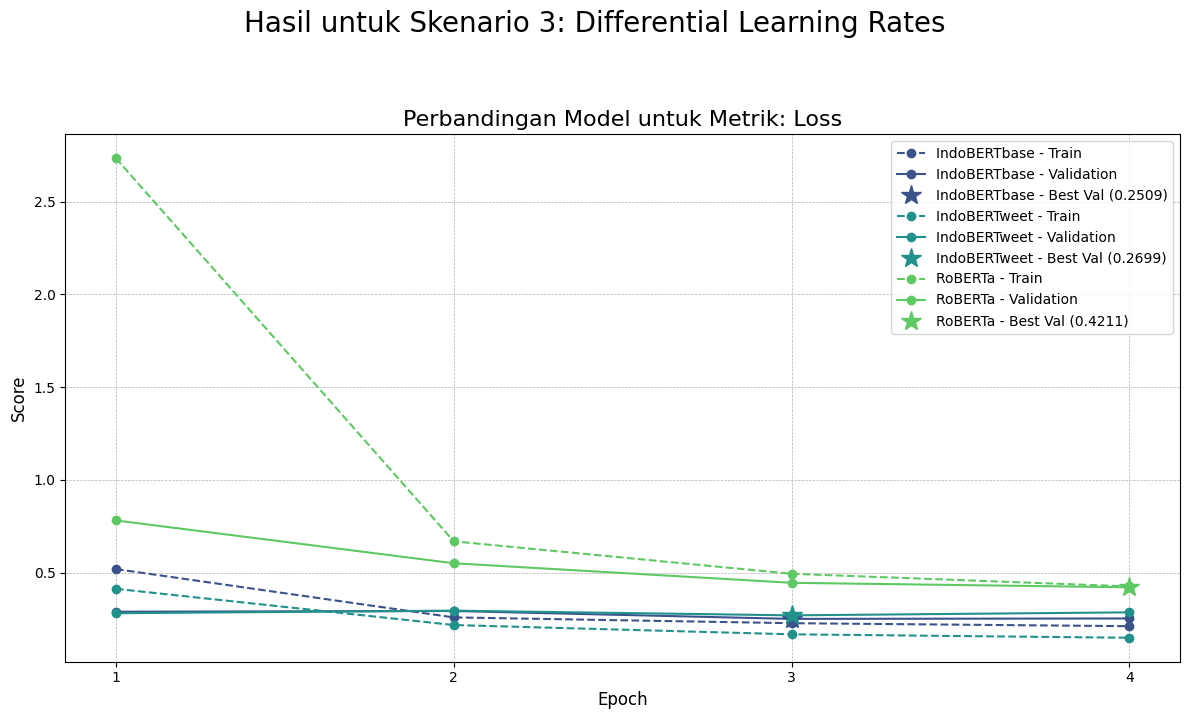

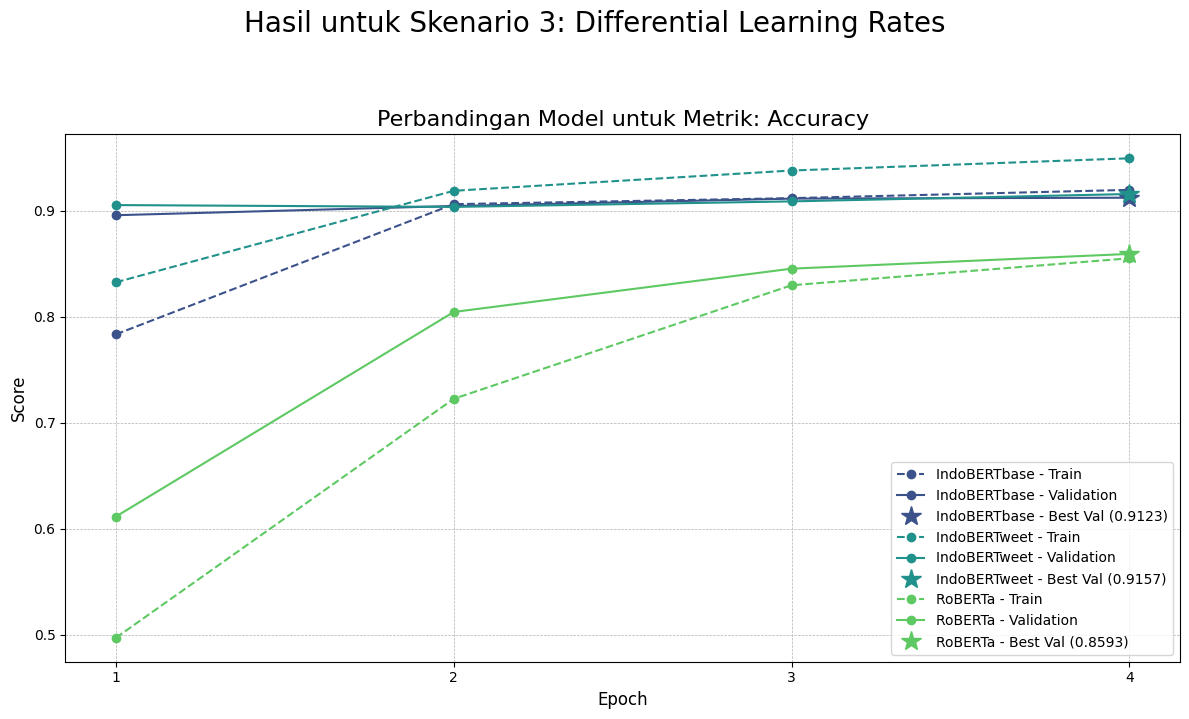

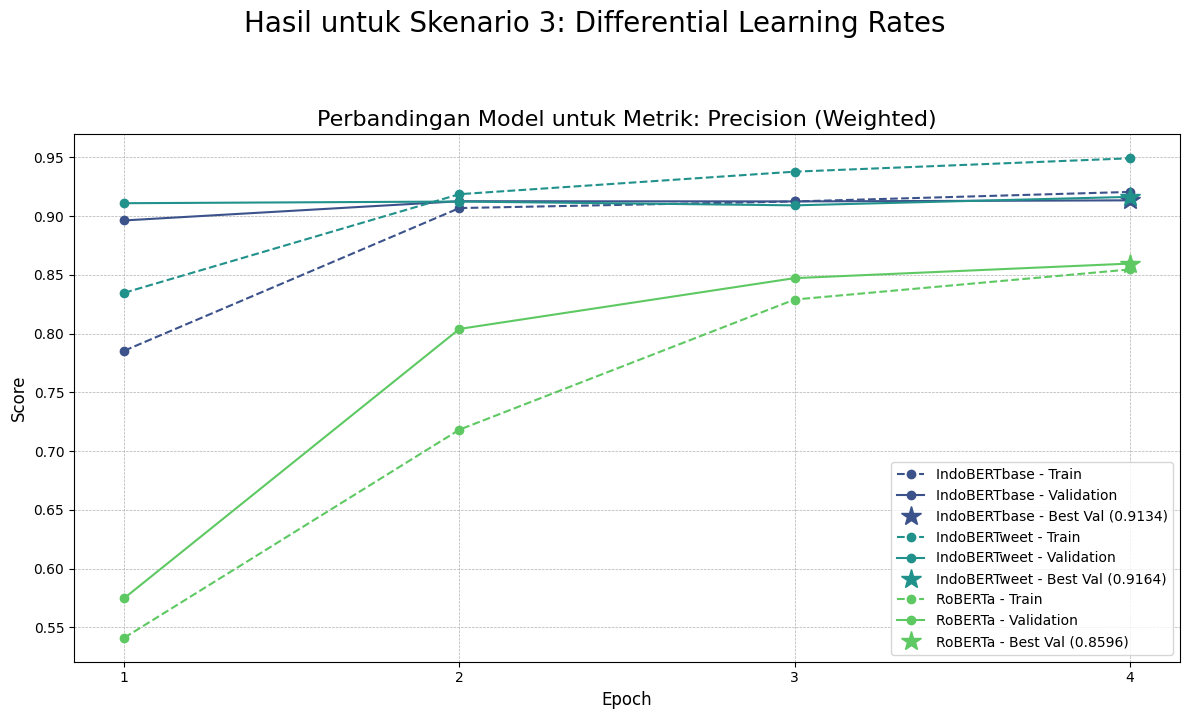

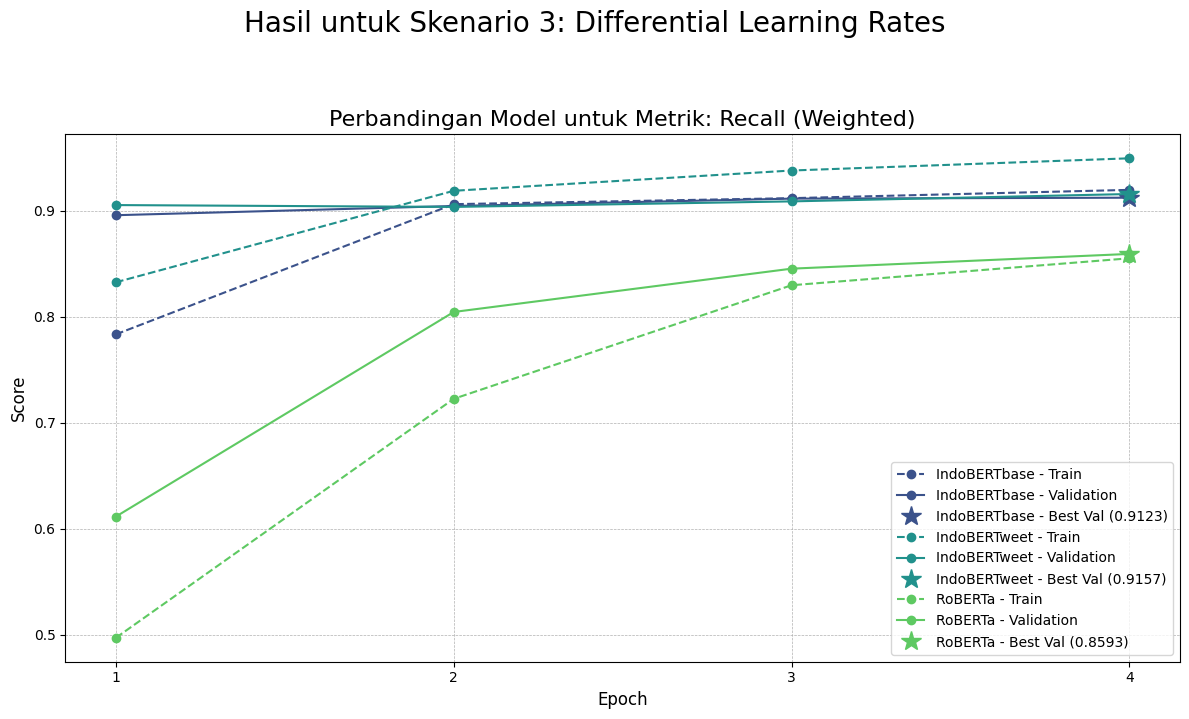

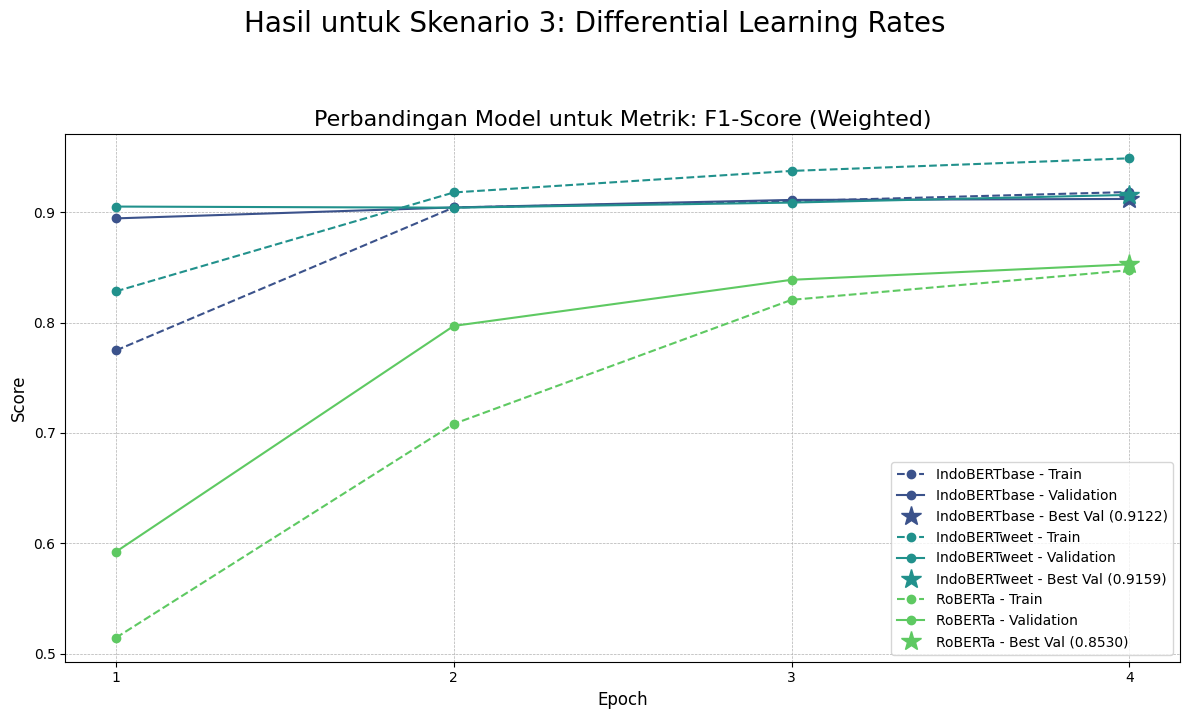

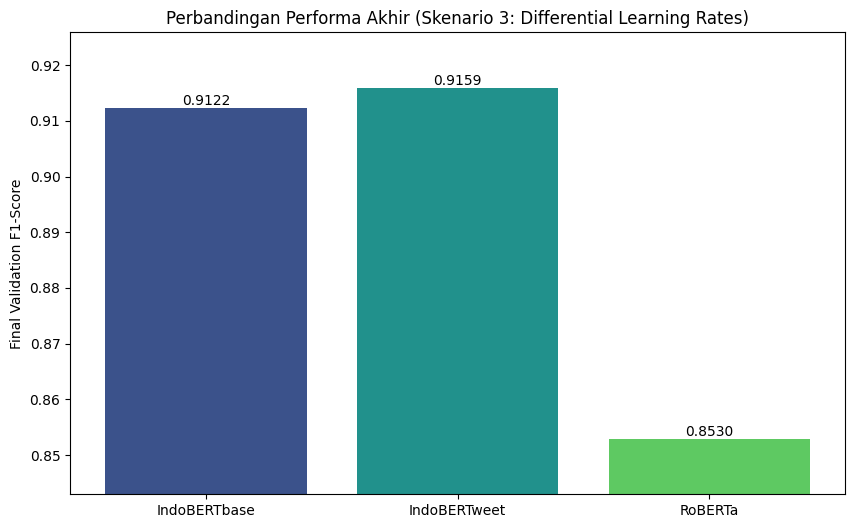

In [11]:
def plot_comprehensive_comparison(histories_dict, scenario_title):
    """Membuat plot perbandingan antar model untuk semua metrik dan menyorot epoch terbaik."""
    metrics_to_plot = ['loss', 'accuracy', 'precision', 'recall', 'f1']
    metric_titles = ['Loss', 'Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)']
    colors = sns.color_palette("viridis", len(histories_dict))
    model_colors = {model_name: color for model_name, color in zip(histories_dict.keys(), colors)}
    
    for i, metric in enumerate(metrics_to_plot):
        plt.figure(figsize=(12, 7))
        ax = plt.gca()
        for model_name, history in histories_dict.items():
            epochs_range = range(1, len(history.get(f'train_{metric}', [])) + 1)
            if not epochs_range: continue # Lewati jika history kosong
            
            ax.plot(epochs_range, history[f'train_{metric}'], 'o--', color=model_colors[model_name], label=f'{model_name} - Train')
            ax.plot(epochs_range, history[f'val_{metric}'], 'o-', color=model_colors[model_name], label=f'{model_name} - Validation')
            
            if metric == 'loss': best_epoch_idx = np.argmin(history[f'val_{metric}'])
            else: best_epoch_idx = np.argmax(history[f'val_{metric}'])
            best_epoch_num = best_epoch_idx + 1
            best_val_score = history[f'val_{metric}'][best_epoch_idx]
            
            ax.plot(best_epoch_num, best_val_score, '*', markersize=15, color=model_colors[model_name], label=f'{model_name} - Best Val ({best_val_score:.4f})')

        ax.set_title(f'Perbandingan Model untuk Metrik: {metric_titles[i]}', fontsize=16)
        ax.set_xlabel('Epoch', fontsize=12); ax.set_ylabel('Score', fontsize=12)
        ax.legend(loc='best', fontsize=10); ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.set_xticks(epochs_range if 'epochs_range' in locals() else [1])
        plt.suptitle(f'Hasil untuk {scenario_title}', fontsize=20, y=1.02); plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

def plot_final_bar_chart(histories_dict, scenario_title):
    """Membuat bar plot perbandingan F1-score validasi terakhir dari semua model."""
    final_f1_scores = {model: history['val_f1'][-1] for model, history in histories_dict.items() if history['val_f1']}
    if not final_f1_scores: return
    
    models = list(final_f1_scores.keys()); scores = list(final_f1_scores.values())
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, scores, color=sns.color_palette("viridis", len(models)))
    plt.ylabel('Final Validation F1-Score'); plt.title(f'Perbandingan Performa Akhir ({scenario_title})')
    plt.ylim(min(scores) - 0.01, max(scores) + 0.01)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center') 
    plt.show()

if all_histories:
    SCENARIO_NAME = "Skenario 3: Differential Learning Rates"
    plot_comprehensive_comparison(all_histories, SCENARIO_NAME)
    plot_final_bar_chart(all_histories, SCENARIO_NAME)
else:
    print("Tidak ada hasil untuk divisualisasikan.")